## 특성 공학 (feature engineering)

- 기존의 특성을 사용해 새로운 특성을 만들어내는 작업
- 특성 공학 기법
  - 차원 축소 (Dimension Reduction)
    - 특성 선정 (Feature Selection)
      - 특성 랭킹 또는 특성 중요도에 따라 선정
      - 분석가의 사전 배경 지식을 이용하거나, 랜덤 선정 및 측정을 반복하는 방법
    - 특성 추출 (Feature Extraction)
      - 특성들의 조합으로 새로운 특성을 생성
  - 스케일링 (Scaling)
    - 변수의 분포가 편향되어 있을 경우, 변수 간의 관계가 잘 드러나지 않는 경우 범위 변환
  - 변형 (Transform)
    - 기존에 존재하는 변수의 성질을 이용해 다른 변수를 생성하는 방법
      - 예) 날짜별 데이터에 주말 여부 추가
  - 비닝 (Binning)
    - 연속형 변수를 범주형 변수로 변환
      - 예) 33세, 47세 -> 30대, 40대
  - 더미 (Dummy)
    - 범주형 변수를 연속형 변수로 변환
    - 기존 특성이나 특성의 조합을 규칙에 따라 수치화하여 추가

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# 데이터 준비

In [4]:
df = pd.read_csv("./data/Fish.csv")

In [7]:
df = df.loc[df["Species"] == "Perch", ["Weight", "Length2", "Height", "Width"]]

In [9]:
df.head()

,Weight,Length2,Height,Width
72,5.9,8.4,2.1120,1.4080
73,32.0,13.7,3.5280,1.9992
74,40.0,15.0,3.8240,2.4320
75,51.5,16.2,4.5924,2.6316
76,70.0,17.4,4.5880,2.9415


In [11]:
df.shape

(56, 4)

In [13]:
x = df.drop("Weight", axis = 1)
y = df["Weight"]

In [15]:
# 75 : 25 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 26)

In [17]:
x_train.shape

(42, 3)

In [19]:
# PolynomialFeatures 사용 예시
pf = PolynomialFeatures()
pf.fit_transform([[2, 3]])

array([[1., 2., 3., 4., 6., 9.]])

In [21]:
# 특성이 어떻게 만들어졌는지 확인
pf.get_feature_names_out()

array(['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2'], dtype=object)

- include_bias : 절편을 추가해주는 파라미터
  - 사이킷런의 선형 회귀 모델은 자동으로 절편을 추가해주기 때문에 굳이 절편을 추가할 필요가 없음

In [24]:
pf = PolynomialFeatures(include_bias = False)
pf.fit_transform([[2, 3]])

array([[2., 3., 4., 6., 9.]])

In [26]:
# 실전 적용
pf = PolynomialFeatures(include_bias = False)
poly_train = pf.fit_transform(x_train)
poly_test = pf.transform(x_test)

- PolynomialFeatures 는 별도의 통계값을 저장하지 않기 때문에 테스트 세트를 함께 변환해도 차이가 없지만 항상 훈련데이터를 기준으로 학습하고 테스트 데이터를 변환하는 습관을 들이는 것이 중요

In [29]:
poly_train.shape

(42, 9)

# 모델 훈련

In [32]:
# 특성공학 적용 전 데이터로 학습한 모델
lr_org = LinearRegression()
lr_org.fit(x_train, y_train)
print(lr_org.score(x_train, y_train)) # 훈련 데이터에 대한 결정 계수
print(lr_org.score(x_test, y_test)) # 테스트 데이터에 대한 결정 계수

0.9415808063901719
0.9315466399890024


In [34]:
# 특성공학 적용 후 데이터로 학습한 모델
lr_poly = LinearRegression()
lr_poly.fit(poly_train, y_train)
print(lr_poly.score(poly_train, y_train))
print(lr_poly.score(poly_test, y_test))

0.9895046545787157
0.9446218812357896


# 모델 최적화

- 특성을 더 추가
  - degree 매개변수 : 고차항 최대 차수를 지정

In [37]:
pf = PolynomialFeatures(degree = 5, include_bias = False)
poly_train5 = pf.fit_transform(x_train)
poly_test5 = pf.transform(x_test)
poly_train5.shape

(42, 55)

In [39]:
lr_poly5 = LinearRegression()
lr_poly5.fit(poly_train5, y_train)
print(lr_poly5.score(poly_train5, y_train))
print(lr_poly5.score(poly_test5, y_test))

0.999999999742424
-4303.891703509032


- 훈련 데이터에 대해서는 완벽하게 학습했음
- 테스트 데이터에 대해서는 분산보다 오차가 큼
  - 데이터의 평균으로 찍는 것 보다 성능이 떨어짐
  - 과대적합이 일어났음

# 규제 (Regularization)

- 머신러닝 모델이 훈련 세트를 과도하게 학습하지 못하도록 방지하는 것
  - 선형 회귀 모델의 경우에는 특성의 기울기 크기를 제한
- 선형 회귀 모델에 규제를 가하는 방법에 따라 릿지(ridge) 모델과 라쏘(lasso) 로 나뉨
- 릿지 모델
  - 계수를 제곱한 값을 제한
  - l2규제
- 라쏘 모델
  - 계수의 절댓값을 제한
  - l1규제

In [43]:
poly_train5

array([[3.90000000e+01, 1.24313000e+01, 7.35140000e+00, ...,
        6.13964494e+04, 3.63075349e+04, 2.14709010e+04],
       [3.60000000e+01, 1.06091000e+01, 6.74080000e+00, ...,
        3.44739789e+04, 2.19040444e+04, 1.39173711e+04],
       [4.00000000e+01, 1.23808000e+01, 7.46240000e+00, ...,
        6.36990550e+04, 3.83939509e+04, 2.31415595e+04],
       ...,
       [4.00000000e+01, 1.17300000e+01, 7.22500000e+00, ...,
        5.18930956e+04, 3.19631386e+04, 1.96874404e+04],
       [1.87000000e+01, 5.19920000e+00, 3.12340000e+00, ...,
        8.23674964e+02, 4.94819661e+02, 2.97261065e+02],
       [4.30000000e+01, 1.25125000e+01, 7.41650000e+00, ...,
        6.38682746e+04, 3.78564682e+04, 2.24385612e+04]])

In [45]:
# 일반적으로 선형 회귀 모델에 규제를 적용할 때 계수 값의 크기가 서로 많이 다르면 제어가 힘듦
# 규제 적용 전에 스케일링을 수행
ss = StandardScaler()
scaled_train = ss.fit_transform(poly_train5)
scaled_test = ss.transform(poly_test5)

# 릿지 회귀

In [48]:
rid = Ridge()
rid.fit(scaled_train, y_train)
print(rid.score(scaled_train, y_train))
print(rid.score(scaled_test, y_test))

0.9885701432124202
0.982956563862928


## 초매개변수(hyperparameter)

- 머신러닝 모델이 학습할 수 없고 사람이 설정해줘야하는 파라미터
- 사이킷런 모델에서 하이퍼파라미터는 클래스의 매개변수로 표현됨

### 릿지 모델 하이퍼파라미터 튜닝

- alpha : 규제의 강도
  - alpha 값이 크면
    - 규제의 강도가 세짐
    - 계수의 값을 줄이고 과소적합을 유도
  - alpha 값이 작으면
    - 규제의 강도가 약해짐
    - 계수의 값을 덜 줄이고 과대적합 가능ㅅㅇ이 커짐

In [52]:
train_hist = []
test_hist = []

alpha_li = [0.001, 0.01, 0.1, 1, 10, 100]

for alpha in alpha_li:
    # 모델 생성
    rid = Ridge(alpha = alpha)
    # 훈련
    rid.fit(scaled_train, y_train)
    # 모델 성능을 저장
    train_hist.append(rid.score(scaled_train, y_train))
    test_hist.append(rid.score(scaled_test, y_test))

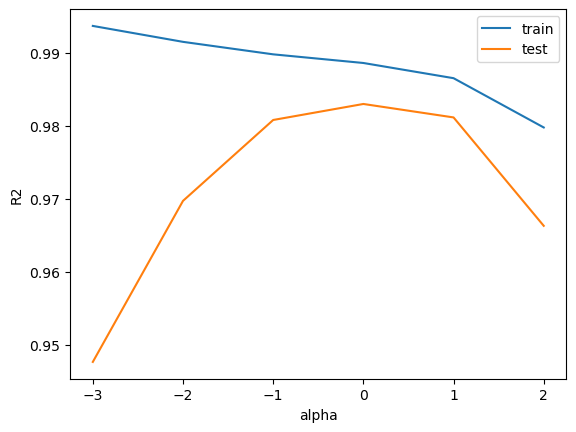

In [54]:
plt.figure()
# alpha 값을 그대로 x에 적용하면 간격이 서로 다르기 때문에 로그 함수로 바꾸어서 시각화
plt.plot(np.log10(alpha_li), train_hist)
plt.plot(np.log10(alpha_li), test_hist)

plt.xlabel("alpha")
plt.ylabel("R2")
plt.legend(labels = ["train", "test"])
plt.show()

- alpha 가 작을 때는 훈련 데이터에만 잘 맞고 테스트 데이터에는 못 맞힘
  - 과대적합이 일어났음
- alpha 가 커질수록 훈련데이터 점수가 낮아짐
  - 과소적합으로 유도되고 있음
- 테스트 데이터에 가장 점수가 높은 alpha 값은 1임

In [57]:
rid = Ridge(alpha = 1)
rid.fit(scaled_train, y_train)
print(rid.score(scaled_train, y_train))
print(rid.score(scaled_test, y_test))

0.9885701432124202
0.982956563862928


# 라쏘 회귀

In [60]:
las = Lasso()
las.fit(scaled_train, y_train)
print(las.score(scaled_train, y_train))
print(las.score(scaled_test, y_test))

0.9882484859311057
0.9815379780476599


## 라쏘 모델 하이퍼파라미터 튜닝

In [63]:
train_hist = []
test_hist = []

alpha_li = [0.001, 0.01, 0.1, 1, 10, 100]

for alpha in alpha_li:
    # 모델 생성
    las = Lasso(alpha = alpha)
    # 훈련
    las.fit(scaled_train, y_train)
    # 모델 성능을 저장
    train_hist.append(las.score(scaled_train, y_train))
    test_hist.append(las.score(scaled_test, y_test))

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.346e+04, tolerance: 4.741e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.088e+04, tolerance: 4.741e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.795e+03, tolerance: 

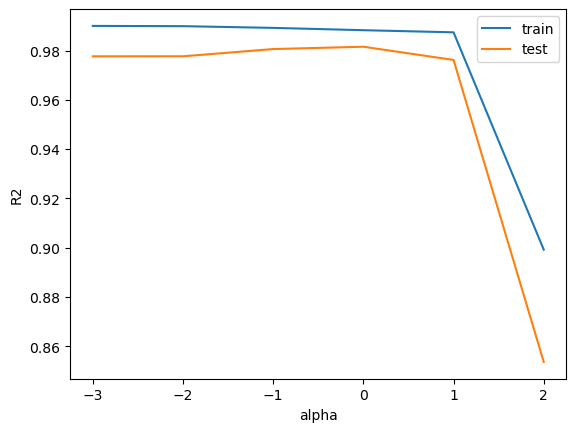

In [65]:
plt.figure()

plt.plot(np.log10(alpha_li), train_hist)
plt.plot(np.log10(alpha_li), test_hist)

plt.xlabel("alpha")
plt.ylabel("R2")
plt.legend(labels = ["train", "test"])
plt.show()

In [67]:
# 모델 성능이 가장 높은 지점 확인
las = Lasso(alpha = 1)
las.fit(scaled_train, y_train)
print(las.score(scaled_train, y_train))
print(las.score(scaled_test, y_test))

0.9882484859311057
0.9815379780476599


In [69]:
las.coef_

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        7.63571451, 17.61220196, 57.16431319, 24.74920949, 48.05301558,
       63.62350726, 37.11374084,  5.94037687, 37.28635893, 10.6388016 ,
        0.        , 11.38663256, 13.06803379,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [71]:
print(np.sum(las.coef_ == 0))

43
